# Project

In [57]:
import math
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
from pyunlocbox import functions, solvers

## Sinan Bursa

In [58]:
credits = pd.read_csv('../../data/tmdb_5000_credits.csv')
credits = credits[credits.cast != '[]']


movies = pd.read_csv('../../data/tmdb_5000_movies.csv')
movies.drop(['homepage', 'keywords','original_language','overview','release_date','spoken_languages', \
             'status','title','tagline','vote_count'\
            ], \
            axis=1, \
            inplace=True \
           )

In [59]:
movies_bechdel = pd.read_pickle('../../data/bechdel.pkl')

In [60]:
movies_bechdel.head()

,budget,genres,id,original_title,popularity,production_companies,production_countries,revenue,runtime,vote_average,bechdel
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,Avatar,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2787965087,162.0,7.2,0.0
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,Pirates of the Caribbean: At World's End,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",961000000,169.0,6.9,1.0
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,Spectre,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",880674609,148.0,6.3,0.0
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,The Dark Knight Rises,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",1084939099,165.0,7.6,0.0
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,John Carter,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",284139100,132.0,6.1,1.0


In [61]:
movies_bechdel = movies_bechdel[['id', 'bechdel']]
len(movies_bechdel)

4140

In [62]:
movies_bechdel['bechdel'].value_counts()

-1.0    1646
 1.0    1358
 0.0    1130
Name: bechdel, dtype: int64

In [63]:
len(credits)

4760

In [64]:
credits = credits.merge(movies_bechdel, left_on='movie_id', right_on='id', how='left').drop(columns=['id'])
credits['bechdel'] = credits['bechdel'].fillna(-1)

In [65]:
credits['bechdel'].value_counts()

-1.0    2273
 1.0    1357
 0.0    1130
Name: bechdel, dtype: int64

In [66]:
len(credits)

4760

In [67]:
credits =credits[credits['bechdel'] != -1].reset_index(drop=True)

In [68]:
len(credits)

2487

In [69]:
credits.drop(['title', 'crew'], axis=1, inplace=True)
credits['cast_id'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['id'])))
#credits['cast_name'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['name'])))
#credits['gender'] = credits['cast'].apply(lambda row: list(set(pd.read_json(row)['gender'])))

In [70]:
frames = pd.DataFrame()
new_df = pd.DataFrame()

for idx, film in credits.iterrows():
    cast_df = pd.DataFrame(eval(credits['cast'][idx]))
    cast_df['credits'] = idx
    cast_df = cast_df.drop(['character','order', 'credit_id', 'cast_id'],axis = 1)  
    
    frames = [new_df, cast_df]
    new_df = pd.concat(frames, join = 'outer', ignore_index=True)

In [71]:
discount_old = credits['cast_id'].apply(pd.Series).stack().value_counts()
discount_old = list(discount_old[discount_old > 4].index.astype(int))
#discount_old[:10]

In [72]:
nodes_df = new_df['credits'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]
discount_1 = nodes_df['id'].tolist()
discount = [x for x in discount_old if x in discount_1]
#nodes_df = nodes_df[nodes_df.id.isin(discount)]
#nodes_df.drop(columns=['credits'], inplace=True)
#nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]

In [73]:
print('Old Values of the Discount')
print(discount_old[:10])
print(len(discount_old))
print('New Values of the Discount')
print(discount[:10])
print(len(discount))

Old Values of the Discount
[2231, 1892, 380, 192, 85, 62, 3896, 287, 884, 388]
2328
New Values of the Discount
[2231, 1892, 380, 192, 85, 62, 3896, 287, 884, 388]
2206


In [74]:
credits_bechdel =credits[credits['bechdel'] == 1].reset_index(drop=True)

In [75]:
print('Values in credits')
print(len(credits))
print('Values in credits that passes bechdel')
print(len(credits_bechdel))

Values in credits
2487
Values in credits that passes bechdel
1357


In [76]:
credits['cast_id'] = credits['cast_id'].apply(lambda x: [y for y in x if y in discount])
credits['edges'] = credits['cast_id'].apply(lambda x: list(itertools.combinations(x, 2)))
credits_bechdel['cast_id'] = credits_bechdel['cast_id'].apply(lambda x: [y for y in x if y in discount])
credits_bechdel['edges'] = credits_bechdel['cast_id'].apply(lambda x: list(itertools.combinations(x, 2)))
edges = list(credits_bechdel['edges'].apply(pd.Series).stack())
edges_total = list(credits['edges'].apply(pd.Series).stack())

edges[0:5]

edges_df = pd.DataFrame(edges)

In [77]:
print('Values in credits')
print(len(credits))
print('Values in credits that passes bechdel')
print(len(credits_bechdel))
print('Lenght of edges with Bechdel')
print(len(edges))

Values in credits
2487
Values in credits that passes bechdel
1357
Lenght of edges with Bechdel
53148


In [78]:
credits.head()

,movie_id,cast,bechdel,cast_id,edges
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...",0.0,"[30485, 42286, 68278, 65731, 42317, 10964, 102...","[(30485, 42286), (30485, 68278), (30485, 65731..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...",1.0,"[2440, 2441, 2449, 1709, 1711, 1714, 22075, 40...","[(2440, 2441), (2440, 2449), (2440, 1709), (24..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...",0.0,"[139549, 17064, 27319, 121529, 5309, 2244, 878...","[(139549, 17064), (139549, 27319), (139549, 12..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...",0.0,"[53252, 77335, 535, 539, 1580574, 22075, 64, 1...","[(53252, 77335), (53252, 535), (53252, 539), (..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...",1.0,"[17287, 17419, 2206, 2983, 5293, 21044, 57675,...","[(17287, 17419), (17287, 2206), (17287, 2983),..."


In [79]:
discarded_movies = set()

for idx, movie in credits.iterrows():
    if len(movie['edges']) == 0:
        discarded_movies.add(movie['movie_id'])

print(len(discarded_movies)) 

90


In [80]:
credits = credits[~credits['movie_id'].isin(discarded_movies)]
credits_bechdel = credits_bechdel[~credits_bechdel['movie_id'].isin(discarded_movies)]
credits.head()

,movie_id,cast,bechdel,cast_id,edges
0,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...",0.0,"[30485, 42286, 68278, 65731, 42317, 10964, 102...","[(30485, 42286), (30485, 68278), (30485, 65731..."
1,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...",1.0,"[2440, 2441, 2449, 1709, 1711, 1714, 22075, 40...","[(2440, 2441), (2440, 2449), (2440, 1709), (24..."
2,206647,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...",0.0,"[139549, 17064, 27319, 121529, 5309, 2244, 878...","[(139549, 17064), (139549, 27319), (139549, 12..."
3,49026,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...",0.0,"[53252, 77335, 535, 539, 1580574, 22075, 64, 1...","[(53252, 77335), (53252, 535), (53252, 539), (..."
4,49529,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...",1.0,"[17287, 17419, 2206, 2983, 5293, 21044, 57675,...","[(17287, 17419), (17287, 2206), (17287, 2983),..."


In [81]:
print('Values in credits')
print(len(credits))
print('Values in credits that passes bechdel')
print(len(credits_bechdel))

Values in credits
2397
Values in credits that passes bechdel
1313


In [82]:
movies['profit'] = movies['revenue']-movies['budget']
movies_credits = movies.merge(credits, left_on='id', right_on='movie_id', how='inner').drop(columns=['movie_id'])

In [83]:
movies_credits = movies_credits[movies_credits.genres != '[]']
movies_credits['genre_id'] = movies_credits['genres'].apply(lambda row: list(pd.read_json(row)['id']))
movies_credits['genre_name'] = movies_credits['genres'].apply(lambda row: list(pd.read_json(row)['name']))

In [84]:
genre = movies_credits[['cast_id', 'genre_id', 'genre_name']]
genre.loc[:, 'genre_id_disc'] = genre['genre_id'].apply(lambda x: x[0])
genre.loc[:, 'genre_name_disc'] = genre['genre_name'].apply(lambda x: x[0])

/Users/sinangokce/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/sinangokce/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [85]:
genre_df = pd.DataFrame(genre.cast_id.tolist(), index=genre.genre_name_disc).stack().reset_index(name='cast_id')[['cast_id','genre_name_disc']]
most_freq_genre = genre_df.groupby(['cast_id']).agg(lambda x:x.value_counts().index[0])

In [86]:
profit_df = pd.DataFrame(movies_credits.cast_id.tolist(), index=movies_credits.profit).stack().reset_index(name='cast_id')[['cast_id','profit']]
profit_df['cast_id'] = profit_df.cast_id.astype(int)
profit_df = profit_df.groupby('cast_id', as_index=False).mean()
profit_df.set_index('cast_id', inplace=True)
profit_df.head()


,profit
cast_id,
3,1.894147e+08
4,2.016314e+08
6,6.157178e+08
7,4.952879e+08
10,6.340370e+08


In [87]:
profit_df = ((profit_df['profit']/(10**7)).round(0))*(10**7)
profit_df = profit_df.to_frame()

In [88]:
ranking_df = pd.DataFrame(movies_credits.cast_id.tolist(), index=movies_credits.vote_average).stack().reset_index(name='cast_id')[['cast_id','vote_average']]
ranking_df['cast_id'] = ranking_df.cast_id.astype(int)
ranking_df = ranking_df.groupby('cast_id', as_index=False).mean()
ranking_df.set_index('cast_id', inplace=True)
ranking_df.head()
     

,vote_average
cast_id,
3,6.816000
4,6.658333
6,7.357143
7,7.340000
10,7.466667


In [89]:
ranking_df = round(ranking_df['vote_average'] * 2) / 2
ranking_df = ranking_df.to_frame()

In [90]:
actors = ranking_df.merge(most_freq_genre, on='cast_id', how='inner')
actors = actors.merge(profit_df, on='cast_id', how='inner')

In [91]:
actors = actors.reset_index()
actors.head()

,cast_id,vote_average,genre_name_disc,profit
0,3,7.0,Adventure,190000000.0
1,4,6.5,Adventure,200000000.0
2,6,7.5,Adventure,620000000.0
3,7,7.5,Animation,500000000.0
4,10,7.5,Animation,630000000.0


In [92]:
#nodes_df = new_df['credits'].groupby([new_df.gender, new_df.id, new_df.name]).apply(list).reset_index()
nodes_df = nodes_df[nodes_df.id.isin(discount)]
nodes_df.drop(columns=['credits'], inplace=True)
#nodes_df = nodes_df[nodes_df['gender'].isin(['1','2'])]

In [93]:
actors = actors.merge(nodes_df, left_on = 'cast_id', right_on='id', how='inner').drop(columns=['cast_id'])

In [94]:
actors[actors['name']=='Leonardo DiCaprio']

,vote_average,genre_name_disc,profit,gender,id,name
643,7.0,Drama,240000000.0,2,6193,Leonardo DiCaprio


In [95]:
actors.sort_values(by='profit', ascending=False)

,vote_average,genre_name_disc,profit,gender,id,name
1622,6.5,Adventure,870000000.0,1,42286,Julene Renee
255,7.5,Adventure,760000000.0,2,1643,Adrian Rawlins
956,7.5,Adventure,750000000.0,2,11212,Josh Herdman
2031,7.5,Adventure,750000000.0,2,96851,James Phelps
2142,7.5,Adventure,750000000.0,2,234922,Devon Murray
928,7.5,Adventure,750000000.0,1,10991,Bonnie Wright
2164,7.5,Adventure,750000000.0,2,956224,Jamie Waylett
2091,7.5,Adventure,750000000.0,2,140368,Oliver Phelps
2030,7.5,Adventure,670000000.0,2,96841,Matthew Lewis
501,7.0,Adventure,640000000.0,2,4031,Greg Ellis


In [96]:
#features = nodes_df.set_index('id').drop('name', axis=1)
#features.head()

In [97]:
discount_df = pd.DataFrame(discount)
features = discount_df.merge(actors, left_on = 0, right_on='id', how='inner').drop(columns=[0])
features.head()

,vote_average,genre_name_disc,profit,gender,id,name
0,6.5,Action,240000000.0,2,2231,Samuel L. Jackson
1,7.0,Drama,130000000.0,2,1892,Matt Damon
2,7.0,Drama,70000000.0,2,380,Robert De Niro
3,7.0,Action,170000000.0,2,192,Morgan Freeman
4,6.5,Adventure,150000000.0,2,85,Johnny Depp


## Doing the Adjacency again
Cause we took out some genders and our size went from 3766 to 3500

In [98]:
len(features)

2206

In [99]:
len(edges)

53148

In [100]:
adj_total = pd.DataFrame(np.zeros(shape=(len(discount),len(discount))), columns=discount, index=discount)
for e1, e2 in edges_total:
    if e1 in discount and e2 in discount:
        adj_total.at[e1, e2] += 1
        adj_total.at[e2, e1] += 1
    else:
        edges_total.remove((e1,e2))

adj_total.head()

,2231,1892,380,192,85,62,3896,287,884,388,...,73417,14548,17837,11022,162828,94428,2467,6860,61111,4689
2231,0.0,0.0,2.0,0.0,0.0,3.0,1.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1892,0.0,0.0,0.0,1.0,0.0,1.0,1.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,1.0,1.0,0.0,1.0,2.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
adj = pd.DataFrame(np.zeros(shape=(len(discount),len(discount))), columns=discount, index=discount)
for e1, e2 in edges:
    if e1 in discount and e2 in discount:
        adj.at[e1, e2] += 1
        adj.at[e2, e1] += 1
    else:
        edges.remove((e1,e2))

adj.head()

,2231,1892,380,192,85,62,3896,287,884,388,...,73417,14548,17837,11022,162828,94428,2467,6860,61111,4689
2231,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
bechdel_adj = adj/adj_total
bechdel_adj.fillna(0, inplace=True)

In [103]:
bechdel_adj.head()

,2231,1892,380,192,85,62,3896,287,884,388,...,73417,14548,17837,11022,162828,94428,2467,6860,61111,4689
2231,0.0,0.0,1.0,0.0,0.0,0.333333,1.00,0.5,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,0.0,0.0,0.0,0.0,0.0,0.000000,1.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
380,1.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192,0.0,0.0,0.0,0.0,0.0,0.000000,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
#IF WE NEED NON WEIGHTED ADJACENCY
adjacency_non_weighted = np.copy(bechdel_adj)
adjacency_non_weighted[adjacency_non_weighted > 0] = 1
adjacency_non_weighted = np.asmatrix(adjacency_non_weighted)

In [111]:
graph = nx.from_numpy_array(adjacency_non_weighted)

In [112]:
node_props = features.to_dict()

In [113]:
for key in node_props:
    nx.set_node_attributes(graph, node_props[key], key)

In [114]:
graph.node[0]

{'vote_average': 6.5,
 'genre_name_disc': 'Action',
 'profit': 240000000.0,
 'gender': 2,
 'id': 2231,
 'name': 'Samuel L. Jackson'}

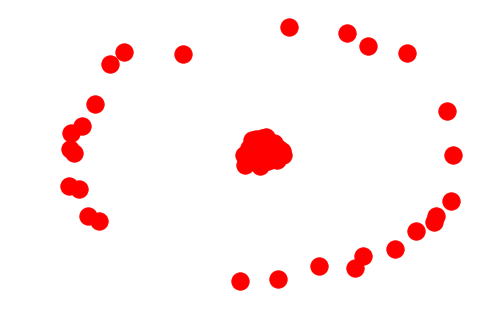

In [115]:
nx.draw_spring(graph)

In [116]:
nx.write_gexf(graph, 'CoAppAdjGephiFile.gexf')

In [117]:
bechdel_adj.to_csv("CoAppadjacency.csv")

In [118]:
features.to_csv("CoAppfeatures.csv")

In [119]:
edges_df.to_csv("CoAppBechdelEdges.csv")